## Complex networks 2025 - Fall
### Practice 02 - 2025.10.21.

Kumpula model, random walk, edge prediction

## Task 1
### Simulate the Kumpula model:

#### Global attachment (GA):
 - c) With probability $p_r$, choose two nodes $i$ and $j$ randomly and connect them. The links weight is set to $w_0$.

#### Local attachment (LA):
 * Select a node $i$ randomly.
 * If $i$ does not have any links than perform a GA with $i$ as one of the nodes and $p_r=1$, and LA is finished
 * Select a neighbor $j$ of the node $i$ with probability proportional to the link weight $W_{ij}$. Increase the weight $W_{ij}$ by $\delta$.
 * If $j$ has one single neighbour (which has to be $i$), then perform a GA with $j$ as one of the nodes and $p_r=1$. LA is finished here
 * Select a neighbor $k$ of the node $j$ with probability proportional to the link weight $W_{jk}$. Increase the weight $W_{jk}$ by $\delta$.
   * b) If $i$ and $k$ are connected, increase the weight of their link by $\delta$ (reinforcement).
   * a) If $i$ and $k$ are not connected, then with probability $p_t$ connect them with weight $w_0$ (friend of friend connection).

#### Link deletion:
 * With probability $p_d$: Remove all links of a random node.

In the model use $w_0=1$.

Change $\delta$ and plot the networks. Try to plot your network with different parameters and compare the results with the online tool: https://yohm.github.io/p5js_simulations/wsn/

![Kumpula model](https://www.researchgate.net/profile/Kunal-Bhattacharya-2/publication/324536263/figure/fig1/AS:615899631460352@1523853323074/Schematic-diagram-of-the-model-by-Kumpula-et-al-2007-a-a-weighted-local-search.png)

In [5]:
import random
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

class KumpulaModel:
    def __init__(self, N, num_steps, pr, pt, pd, delta_w, w0=1.0):
        self.N = N
        self.num_steps = num_steps
        self.pr = pr
        self.pt = pt
        self.pd = pd
        self.delta_w = delta_w
        self.w0 = w0

        self.create_graph()
    
    def create_graph(self):
        self.G = nx.Graph()
        self.G.add_nodes_from(range(self.N))

        self.init_GA()

        for step in range(self.num_steps):
            self.LA_step()
            self.LD_step()
    
    def GA_step(self, i, j, p):
        if random.random() <= p:
            self.G.add_edge(i, j, weight=self.w0)

    def init_GA(self):
        for i in range(len(self.G.nodes)):
            for j in range(i+1, len(self.G.nodes)):
                self.GA_step(i, j, self.pr)
    
    def select_neighbor_weighted(self, node, neighbors):
        neighbor_weights = [self.G[node][nbr]['weight'] for nbr in neighbors]
        total_weight = sum(neighbor_weights)
        probabilities = [w / total_weight for w in neighbor_weights]
        return random.choices(neighbors, weights=probabilities)[0]

    def LA_step(self):
        i = random.choice(list(self.G.nodes()))
        i_neighbors = list(self.G.neighbors(i))

        if len(i_neighbors) == 0:
            j = random.choice(list(set(self.G.nodes) - {i}))
            self.GA_step(i, j, 1.0)
            return
        
        j = self.select_neighbor_weighted(i, i_neighbors)
        self.G[i][j]['weight'] += self.delta_w
        j_neighbors = list(self.G.neighbors(j))
        j_neighbors = [nbr for nbr in j_neighbors if nbr != i]

        if len(j_neighbors) == 0:
            k = random.choice(list(set(self.G.nodes) - {i, j}))
            self.GA_step(j, k, 1.0)
            return

        k = self.select_neighbor_weighted(j, j_neighbors)
        self.G[j][k]['weight'] += self.delta_w
        if not self.G.has_edge(i, k):
            self.GA_step(i, k, self.pt)
        else:
            self.G[i][k]['weight'] += self.delta_w
    
    def LD_step(self):
        if random.random() < self.pd:
            node = random.choice(list(self.G.nodes()))
            edges_to_remove = list(self.G.edges(node))
            self.G.remove_edges_from(edges_to_remove)



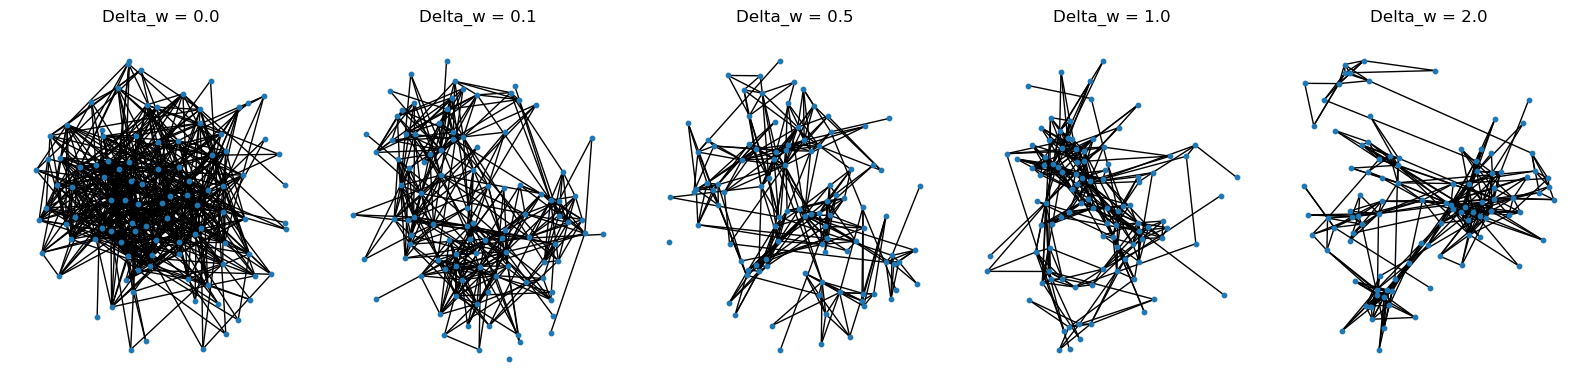

In [17]:
N = 100
num_steps = 200*N
pr = 0.005
pt = 0.1
pd = 0.005
delta_ws = [0.0, 0.1, 0.5, 1.0, 2.0]

fig, axs = plt.subplots(1, len(delta_ws), figsize=(16, 4))

for ax, delta_w in zip(axs, delta_ws):
    model = KumpulaModel(N, num_steps, pr, pt, pd, delta_w)
    G = model.G
    nx.draw(G, pos=nx.spring_layout(G, k=0.9, iterations=40), node_size=10, ax=ax) 
    ax.set_title(f'Delta_w = {delta_w}')

plt.tight_layout()
plt.show()

## Taks 2

Implement a random walk on a graph.
- Plot the $D_t(t)$: Number of distinct nodes visited until time $t$.
- Plot the probability of finding the walker on a given node as a color map on the graph.

Test your solution on the Kumpula model and a Watts-Strogatz graph. Please do not forget enseble average!


In [18]:
def random_walk_ensemble(G, num_steps, num_walks, start_node=None):
    nodes = list(G.nodes())
    node_visit_counts = {node: 0 for node in nodes}
    D_t_ensemble = []
    
    for walk_num in range(num_walks):
        if start_node is None:
            current_node = random.choice(nodes)
        else:
            current_node = start_node
        
        visited_nodes = set([current_node])
        D_t = [1]  # Number of distinct nodes at each time step
        
        for step in range(num_steps):
            # Count visit to current node
            node_visit_counts[current_node] += 1
            
            # Get neighbors
            neighbors = list(G.neighbors(current_node))
            if len(neighbors) == 0:
                break  # Dead end
            
            # Move to random neighbor
            current_node = random.choice(neighbors)
            
            # Track distinct nodes
            visited_nodes.add(current_node)
            D_t.append(len(visited_nodes))
        
        D_t_ensemble.append(D_t)
    
    # Calculate probabilities
    total_visits = sum(node_visit_counts.values())
    node_probabilities = {node: count / total_visits 
                         for node, count in node_visit_counts.items()}
    
    # Average D_t across ensemble
    max_len = max(len(d) for d in D_t_ensemble)
    D_t_avg = []
    for t in range(max_len):
        values = [d[t] for d in D_t_ensemble if t < len(d)]
        D_t_avg.append(np.mean(values))
    
    return node_probabilities, D_t_avg

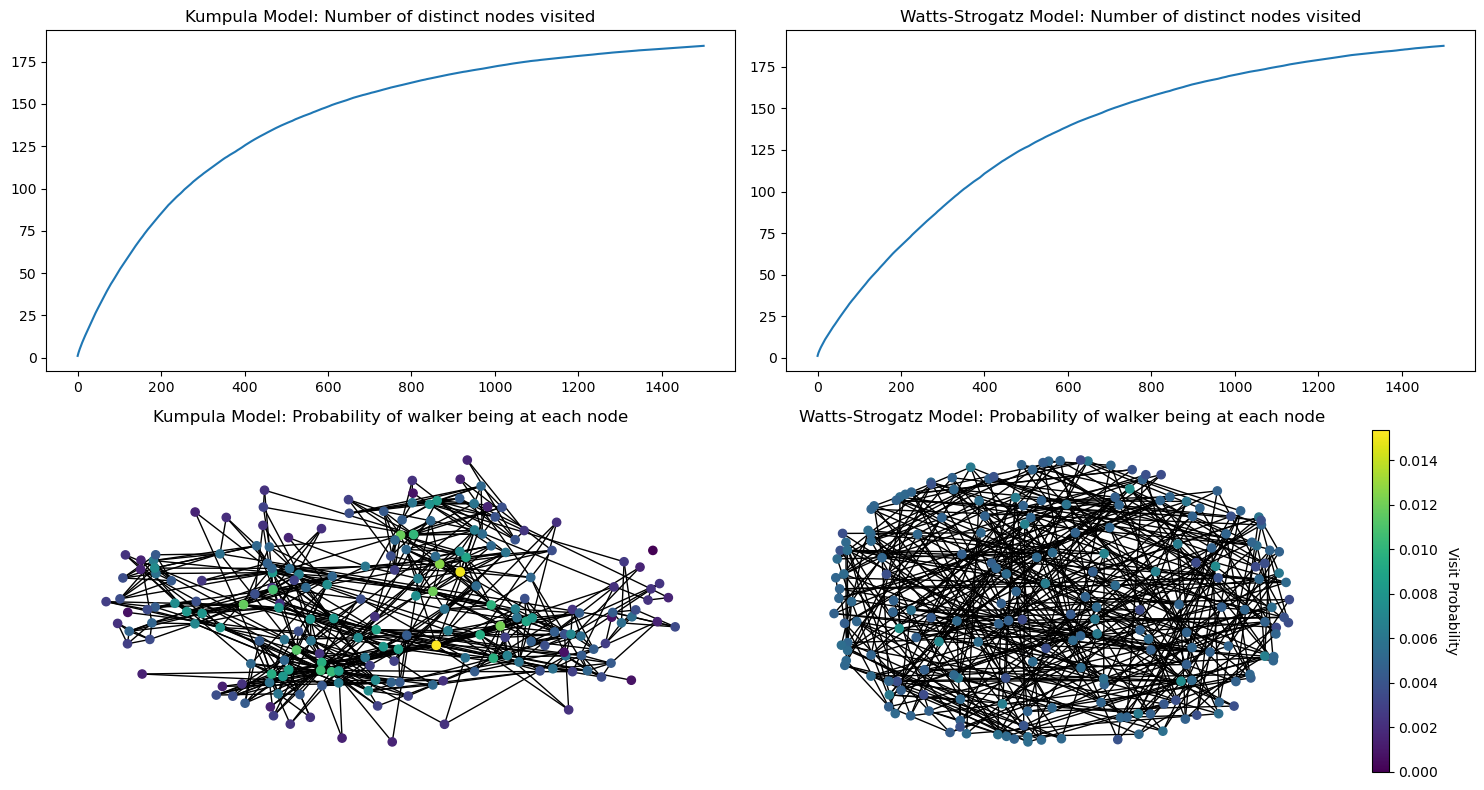

In [25]:
N = 200
num_steps = 200*N
pr = 0.005
pt = 0.1
pd = 0.005
delta_w = 0.9

model = KumpulaModel(N, num_steps, pr, pt, pd, delta_w)
G1 = model.G
node_probabilities1, D_t_avg1 = random_walk_ensemble(G1, num_steps=1500, num_walks=400)
node_colors1 = [node_probabilities1[node] for node in G1.nodes()]

G2 = nx.watts_strogatz_graph(N, k=4, p=0.1)
node_probabilities2, D_t_avg2 = random_walk_ensemble(G2, num_steps=1500, num_walks=400)
node_colors2 = [node_probabilities2[node] for node in G2.nodes()]

color_max = max(max(node_colors1), max(node_colors2))

fig, axes = plt.subplots(2, 2, figsize=(15, 8))
ax1, ax2 = axes[0, 0], axes[0, 1]  # Top row
ax3, ax4 = axes[1, 0], axes[1, 1]  # Bottom row

# First subplot - G1
ax1.plot(range(len(D_t_avg1)), D_t_avg1)
ax1.set_title('Kumpula Model: Number of distinct nodes visited')

# Second subplot - G2
ax2.plot(range(len(D_t_avg2)), D_t_avg2)
ax2.set_title('Watts-Strogatz Model: Number of distinct nodes visited')

# Third subplot - G1
nx.draw(G1, 
    pos=nx.spring_layout(G1, k=0.9, iterations=40), 
    node_color=node_colors1,
    node_size=35,
    # cmap='YlOrRd', 
    vmin=0, 
    vmax=color_max, 
    ax=ax3)
ax3.set_title('Kumpula Model: Probability of walker being at each node')

# Forth subplot - G2
nx.draw(G2, 
    pos=nx.spring_layout(G2, k=0.9, iterations=40),
    node_color=node_colors2,
    node_size=35, 
    vmin=0, 
    vmax=color_max, 
    ax=ax4)
ax4.set_title('Watts-Strogatz Model: Probability of walker being at each node')

sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=0, vmax=color_max))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax4)
cbar.set_label('Visit Probability', rotation=270, labelpad=15)


plt.tight_layout()
plt.show()